# Benchmarking Compute Solutions for CNN Training
# A Case Study with Google Cloud Vertex AI Workbench Managed Notebook Instance with Tesla T4 (16GB)

In [1]:
# Import libs
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time
import matplotlib.pyplot as plt

2023-06-04 10:49:35.437878: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-04 10:49:39.046219: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-04 10:49:46.934288: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-06-04 10:49:46.934615: W tensorfl

In [4]:
!pip install py-cpuinfo

In [5]:
import psutil
import cpuinfo

# Get CPU info
info = cpuinfo.get_cpu_info()

print('CPU Model: ', info['brand_raw'])
print('CPU Cores: ', psutil.cpu_count(logical=False)) # physical cores
print('CPU Threads: ', psutil.cpu_count(logical=True)) # logical cores i.e. with hyperthreading

CPU Model:  Intel(R) Xeon(R) CPU @ 2.00GHz
CPU Cores:  4
CPU Threads:  8


In [6]:
# Get GPU model

if tf.test.is_gpu_available():
    #print("GPU")
    #print("GPU #0?")
    #print(tf.test.gpu_device_name())

    from tensorflow.python.client import device_lib
    #print("GPU #0 detailed info")
    print(device_lib.list_local_devices()[1])
else:
    print("No GPU detected")



Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14244315136
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12071419186924564062
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419



2023-06-04 10:52:12.273234: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-04 10:52:14.503666: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-04 10:52:15.263443: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-04 10:52:15.265323: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [7]:
# Define directories
train_dir = '/home/jupyter/cat-vs-dogs-kaggle/train/'
test_dir = '/home/jupyter/cat-vs-dogs-kaggle/test/'

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,  # This is the source directory for training images
    target_size=(150, 150),  # All images will be resized to 150x150
    batch_size=20,
    # Since we use binary_cross entropy loss, we need binary labels
    class_mode='binary')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 24000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
# Model
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

2023-06-04 10:52:36.962129: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-04 10:52:36.964073: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-04 10:52:36.965666: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-04 10:52:36.967849: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-04 10:52:36.969471: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [9]:
model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [10]:
start_time = time.time()
print(f'\nMODEL TRAINING:')
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    verbose=1
)
print(f"DNN training time: {time.time() - start_time} seconds")


MODEL TRAINING:
Epoch 1/15


2023-06-04 10:52:47.975109: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200
2023-06-04 10:52:55.331495: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-04 10:52:55.332298: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-04 10:52:55.332357: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-06-04 10:52:55.333167: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-06-04 10:52:55.333267: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1200/1200 [==============================] - 172s 121ms/step - loss: 0.5636 - accuracy: 0.7085 - val_loss: 0.4743 - val_accuracy: 0.7750
Epoch 2/15
1200/1200 [==============================] - 41s 34ms/step - loss: 0.4490 - accuracy: 0.7912 - val_loss: 0.3882 - val_accuracy: 0.8250
Epoch 3/15
1200/1200 [==============================] - 39s 32ms/step - loss: 0.3924 - accuracy: 0.8265 - val_loss: 0.3718 - val_accuracy: 0.8480
Epoch 4/15
1200/1200 [==============================] - 41s 34ms/step - loss: 0.3522 - accuracy: 0.8500 - val_loss: 0.3507 - val_accuracy: 0.8500
Epoch 5/15
1200/1200 [==============================] - 41s 34ms/step - loss: 0.3239 - accuracy: 0.8689 - val_loss: 0.3419 - val_accuracy: 0.8460
Epoch 6/15
1200/1200 [==============================] - 39s 33ms/step - loss: 0.2966 - accuracy: 0.8793 - val_loss: 0.4308 - val_accuracy: 0.8560
Epoch 7/15
1200/1200 [==============================] - 41s 35ms/step - loss: 0.2813 - accuracy: 0.8918 - val_loss: 0.4044 - val_accu

In [11]:
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

50/50 [==============================] - 2s 30ms/step - loss: 0.5235 - accuracy: 0.8500
Validation Loss: 0.5234841704368591
Validation Accuracy: 0.8500000238418579


In [12]:
# Save Model
model.save('/Users/tharindu/Downloads/cat-vs-dogs-kaggle/cat-dog-model.keras', save_format='tf')

PermissionDeniedError: /Users; Permission denied

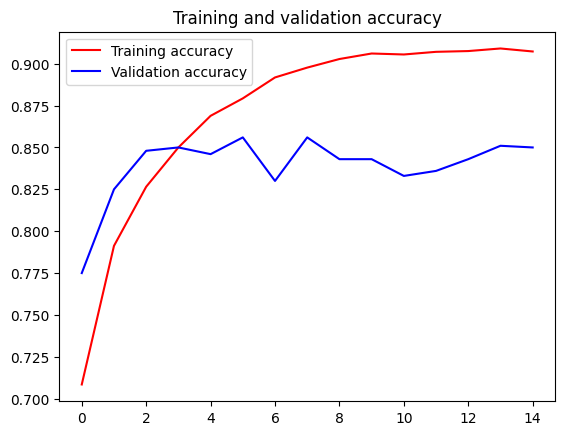

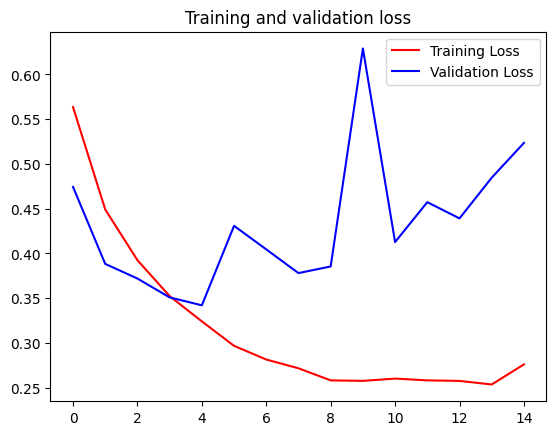

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
